In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
import matplotlib
from qutip import qeye, tensor, destroy, fock_dm, basis
from qutip import sigmax, sigmay, sigmaz, sigmap, sigmam
from qutip import operator_to_vector, vector_to_operator
from qutip import rx, ry, mesolve, thermal_dm, expect, fidelity, ptrace
import random
from numpy import exp, pi, sqrt, sin, cos
import pylab as pyl

In [2]:
e = 1.60217657e-19
m = 9.10938356e-31
# hbar = 1.05457148e-34
nq = 2 # number of qubit states
nHO = 10 # nHO: dimension of H0 space (motional states) which is simulated
nbar_mode = 0.0 # nbar_mode: mean thermal population of motional mode
n_dot = 0 # heating rate
delta_sqg = 2*pi*1e6 # delta: single qubit gate detuning
omega_rabi = 2*pi*2e6 # omega_rabi: single qubit gate Rabi frequency
T = 25e-6 # T: elapsed time
tau_mot = 0 # tau_mot: motional coherence time, =0 for infinity
tau_spin = 0 # tau_spin: spin coherence time, =0 for infinity

In [3]:
# single qubit operators
up_up = fock_dm(2,0) # |up><up|
dn_dn = fock_dm(2,1) # |dn><dn|
sz = up_up - dn_dn
up = basis(2,0) # |up>
dn = basis(2,1) # |dn>
pl = (up+dn)/2 # |+>
mn = (up-dn)/2 # |->
pp = pl*pl.dag() # |+><+|
mm = mn*mn.dag() # |-><-|
pm = pl*mn.dag() # |+><-|
mp = mn*pl.dag() # |-><+|

# two qubit operators
uu_uu = tensor(up_up,up_up) # |up,up><up,up|
dd_dd = tensor(dn_dn,dn_dn) # |dn,dn><dn,dn|
# ud_ud = tensor(up_dn,up_dn) #|up,up><dn,dn|
# du_du = tensor(dn_up,dn_up) #|dn,dn><up,up|
ud_ud = tensor(sigmap(),sigmap()) # |up,up><dn,dn|
du_du = tensor(sigmam(),sigmam()) #  |dn,dn><up,up|

pp_pp = tensor(pp,pp) # |+,+><+,+|
mm_mm = tensor(mm,mm) # |-,-><-,-|
# pm_pm = tensor(pm,pm) # |+,-><+,-|. ? |+,+><-,-|
# mp_mp = tensor(mp,mp) # |-,+><-,+|. ? |-,-><+,+|

# two qubit operators with HO, o* means tensor product
uu_id = tensor(up_up,qeye(nq),qeye(nHO)) # |up><up| o* id
id_uu = tensor(qeye(nq),up_up,qeye(nHO)) # id o* |up><up|
dd_id = tensor(dn_dn,qeye(nq),qeye(nHO)) # |dn><dn| o* id
id_dd = tensor(qeye(nq),dn_dn,qeye(nHO)) # id o* |dn>
sp_id = tensor(sigmap(),qeye(nq),qeye(nHO)) # |up><dn| o* id
id_sp = tensor(qeye(nq),sigmap(),qeye(nHO)) # id o* |up><dn|
sm_id = tensor(sigmam(),qeye(nq),qeye(nHO)) # |dn><up| o* id
id_sm = tensor(qeye(nq),sigmam(),qeye(nHO)) # id o* |dn>
# readout projection operators   
spin_dndn = tensor(dn_dn,dn_dn,qeye(nHO))
spin_upup = tensor(up_up,up_up,qeye(nHO))
spin_updn_dnup = tensor(up_up,dn_dn,qeye(nHO))+tensor(dn_dn,up_up,qeye(nHO))
spin_updn = tensor(up_up,dn_dn,qeye(nHO))
spin_dnup = tensor(dn_dn,up_up,qeye(nHO))

spin_pp = tensor(pp,pp,qeye(nHO))
spin_mm = tensor(mm,mm,qeye(nHO))
spin_pm = tensor(pp,mm,qeye(nHO))
spin_mp = tensor(mm,pp,qeye(nHO))

spin_up = tensor(up_up,qeye(nHO))
spin_dn = tensor(dn_dn,qeye(nHO))

    
# annihilation operator
a = tensor(qeye(nq),qeye(nq),destroy(nHO))
ad = a.dag()

a_sqg = tensor(qeye(nq),destroy(nHO))
ad_sqg = a_sqg.dag()

In [4]:
def sig_phi(phi):
    # Pauli sigma phi operator
    sig_phi = sigmax()*cos(phi)+sigmay()*sin(phi)
    return sig_phi

def sig_phi_i(i,nHO,phi=pi/2,nq=2):
    # Pauli sigma phi operator either acting on ion 1, or ion 2
    if i is 1:
        sig_phi_i = tensor(sig_phi(phi),qeye(nq),qeye(nHO))
    elif i is 2:
        sig_phi_i = tensor(qeye(nq),sig_phi(phi),qeye(nHO))
    return sig_phi_i

# single qubit rotation, on ion 1, ion 2 or both
def U_rot(theta,nHO,ion_index=[1,1],phi=0,nq=2): 
    # ion_index=[i1,i2], do gate on ion ii if ii==1, else, do identity
    # rotation about n axis where n = (cos(phi),sin(phi),0)
    if ion_index[0] == 1:
        op_1 = (cos(theta/2)*qeye(nq))-(1j*sin(theta/2)*(cos(phi)*sigmax()+sin(phi)*sigmay()))
    else:
        op_1 = qeye(nq)
    if ion_index[1] == 1:
        op_2 = (cos(theta/2)*qeye(nq))-(1j*sin(theta/2)*(cos(phi)*sigmax()+sin(phi)*sigmay()))
    else:
        op_2 = qeye(nq)
    rot=tensor(op_1,op_2,qeye(nHO))
    return rot



In [5]:
def sqg(rho_in, times, nq, nHO, phi_offset, omega_rabi,delta_sqg, n_dot, nbar_mode, tau_mot,tau_spin,field_homogeneity, omega_inhomo):
    # single qubit gate hamiltonian, time independent parts
    H1  = -0.5*delta_sqg*tensor(sigmaz(),qeye(nHO))
    H2  = 0.5*omega_rabi*tensor(sigmax(),qeye(nHO))
    # combine
    H_sqg = H1+H2
    # decay (collapse) operators
    c_ops = []
    if n_dot is not 0:
#         c_ops.append(sqrt(n_dot*(nbar_mode+1))*a_sqg)
#         c_ops.append(sqrt(n_dot*nbar_mode)*ad_sqg)
        c_ops.append(sqrt(n_dot)*a_sqg)
        c_ops.append(sqrt(n_dot)*ad_sqg)
    if tau_mot is not 0:
        c_ops.append(sqrt(2/tau_mot)*ad_sqg*a_sqg)
    if tau_spin is not 0:
        c_ops.append(sqrt(1/tau_spin/2)*tensor(sz,qeye(nHO)))
#         c_ops.append(sqrt(1/tau_spin/2)*tensor(qeye(nq),sz,qeye(nHO)))
    # integrate Hamiltonian
    if field_homogeneity is not 0:
        H3 = 0.5*omega_inhomo*tensor(sigmax(),qeye(nHO))*(2*ad_sqg*a_sqg+1)
        H_sqg = H_sqg+H3
    after_sqg = mesolve(H_sqg, rho_in, times, c_ops, [])
    return after_sqg


def do_single_qubit_gate(T, nT=2,nq=2, nHO=10,phi_offset=0, omega_rabi=2*pi*80e3,delta_sqg= 2*pi*40e3, n_dot=0, nbar_mode=0, tau_mot=0,tau_spin=0,field_homogeneity=0,omega_inhomo=0):
    times = np.linspace(0, T, nT)
    # initialize result vector
    final_rhos = []
    # GATE
    # -------------------------------------------------------------------------
    # initial state
    rhoInitial = tensor(qeye(nq)/2-sigmaz()/2,thermal_dm(nHO,nbar_mode)) # initial condition, spin dn
    rho_before_sqg_interaction = rhoInitial
    # do gate
    after_sqg = sqg(rho_before_sqg_interaction, times,nq=nq, nHO=nHO, phi_offset=phi_offset, omega_rabi=omega_rabi,delta_sqg= delta_sqg, n_dot=n_dot, nbar_mode=nbar_mode, tau_mot=tau_mot,tau_spin=tau_spin, field_homogeneity=field_homogeneity,omega_inhomo=omega_inhomo )
    # finish Ramsey interferometer/ do second part of gate
    for ii in range(len(times)):
        rho_t = after_sqg.states[ii]
        final_rho = rho_t
        # final results
        final_rhos.append(final_rho)
    return times, final_rhos

def sqg_timescan(T, nT,nq, nHO,phi_offset, omega_rabi,delta_sqg, n_dot, nbar_mode, tau_mot,tau_spin,field_homogeneity,omega_inhomo):
    # do a single qubit gate dynamics time scan
    # !!! If parameters are not separately specified, chooses optimal gate parameters
    # for programmed gate detuning

    # initialize result vectors
    end_populations_dn = []
    end_populations_up = []
    fidelities = []

    times, final_rhos = do_single_qubit_gate(T=T, nT=nT,nq=nq, nHO=nHO,phi_offset=phi_offset, omega_rabi=omega_rabi,delta_sqg= delta_sqg, n_dot=n_dot, nbar_mode=nbar_mode, tau_mot=tau_mot,tau_spin=tau_spin, field_homogeneity=field_homogeneity,omega_inhomo=omega_inhomo)

    for ii in range(len(times)):

        end_populations_up.append(expect(spin_up,final_rhos[ii]))
        end_populations_dn.append(expect(spin_dn,final_rhos[ii]))
        

        rho_target = up_up # target condition, spin up
        fidelities.append(fidelity(rho_target,ptrace(final_rhos[ii],[0]))**2)

    return times, end_populations_up, end_populations_dn, fidelities


1.986035208512149e-07


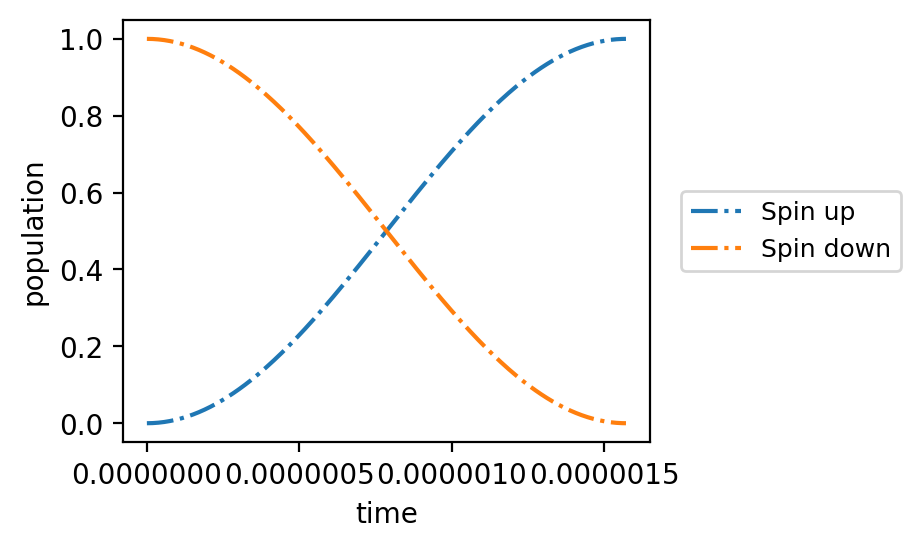

In [6]:
delta_sqg = 0 # 1e6 # delta: single qubit gate detuning
omega_rabi = 2e6
T = pi/omega_rabi
field_homogeneity=0
omega_inhomo=0
times, p_up, p_dn, fidelities = sqg_timescan(T=T,nT=250,nq=2,nHO=10,phi_offset=0, omega_rabi=omega_rabi,delta_sqg= delta_sqg, n_dot=10000, nbar_mode=40, tau_mot=0,tau_spin=0, field_homogeneity=field_homogeneity,omega_inhomo=omega_inhomo)
plt.subplots(figsize=(3.4,2.8),dpi=200)
plt.plot(times,p_up,'-.',label='Spin up')
plt.plot(times,p_dn, '-.',label='Spin down')
plt.ylabel('population')
plt.xlabel('time')
# plt.ylim([-0.01,1.01])
# plt.legend(fontsize=15,handlelength=1)
plt.legend(fontsize = 9, loc='center right', bbox_to_anchor=(1.5, 0.5))
print(1-fidelities[-1])